## importando a base de dados nescessaria

In [1]:
!pip install mlforecast
!pip install lightgbm
!pip install xgboost

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from typing import List
import pickle

import mlforecast
from mlforecast import MLForecast

from utilsforecast.losses import mae, mape, rmse, smape
from utilsforecast.evaluation import evaluate

from utilsforecast.plotting import plot_series

import lightgbm as lgb
from sklearn.base import BaseEstimator
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor

from mlforecast import MLForecast
from sklearn.ensemble import ExtraTreesRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, AdaBoostRegressor
import lightgbm as lgb
from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

from mlforecast.auto import (
    AutoLightGBM,
    AutoMLForecast,
    AutoModel,
    AutoRidge,
    ridge_space,
    AutoRandomForest,
    AutoXGBoost,
    AutoLinearRegression,
    AutoLasso,
    AutoElasticNet,
    AutoCatboost,
    xgboost_space,
    catboost_space,
    random_forest_space
)

import warnings
warnings.filterwarnings('ignore')

### Funções

In [3]:
def acf_pacf(x, qtd_lag):
    fig = plt.figure(figsize=(16,10))
    ax1 = fig.add_subplot(221)
    fig = sm.graphics.tsa.plot_acf(x, lags=qtd_lag, ax=ax1)
    ax2 = fig.add_subplot(222)
    fig = sm.graphics.tsa.plot_pacf(x, lags=qtd_lag, ax=ax2)
    plt.show()

## Importando a base de dados

In [4]:
bucket_uri = "gs://m5_dados/M5_full.parquet"

In [5]:
data = pd.read_parquet(bucket_uri)

In [6]:
data

,id,item_id,dept_id,cat_id,store_id,state_id,value,date
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29
...,...,...,...,...,...,...,...,...
59181085,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,1,2016-05-22
59181086,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,2016-05-22
59181087,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,2,2016-05-22
59181088,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,2016-05-22


In [7]:
data['id'].nunique()

30490

In [8]:
data['item_id'].nunique()

3049

In [9]:
data['dept_id'].nunique()

7

In [10]:
data['cat_id'].nunique()

3

In [11]:
data['store_id'].nunique()

10

In [12]:
data['state_id'].nunique()

3

In [13]:
data['date'] = pd.to_datetime(data['date'])

In [14]:
data = data.set_index('date')

## Previsão por categoria (cat_id): ✅


In [15]:
df_cat_id = data.groupby(['cat_id']).resample('M')['value'].sum()

In [16]:
df_cat_id.to_frame()

value
cat_id    date              
FOODS     2011-01-31   63110
          2011-02-28  520250
          2011-03-31  534914
          2011-04-30  509568
          2011-05-31  491753
...                      ...
HOUSEHOLD 2016-01-31  290293
          2016-02-29  295249
          2016-03-31  304051
          2016-04-30  304291
          2016-05-31  226486

[195 rows x 1 columns]

In [17]:
df_cat_id_reset_index = df_cat_id.reset_index()

In [18]:
df_nixtla_4 = pd.DataFrame({
    'unique_id': df_cat_id_reset_index['cat_id'],
    'ds': df_cat_id_reset_index['date'],
    'y': df_cat_id_reset_index['value']
})

In [19]:
df_nixtla_4

,unique_id,ds,y
0,FOODS,2011-01-31,63110
1,FOODS,2011-02-28,520250
2,FOODS,2011-03-31,534914
3,FOODS,2011-04-30,509568
4,FOODS,2011-05-31,491753
...,...,...,...
190,HOUSEHOLD,2016-01-31,290293
191,HOUSEHOLD,2016-02-29,295249
192,HOUSEHOLD,2016-03-31,304051
193,HOUSEHOLD,2016-04-30,304291


In [20]:
df_nixtla_4['ds'] = pd.to_datetime(df_nixtla_4['ds'])

In [21]:
df_nixtla_4['unique_id'].value_counts().sum()

195

In [22]:
df_test = df_nixtla_4.groupby('unique_id').tail(6)
df_train = df_nixtla_4.drop(df_test.index)

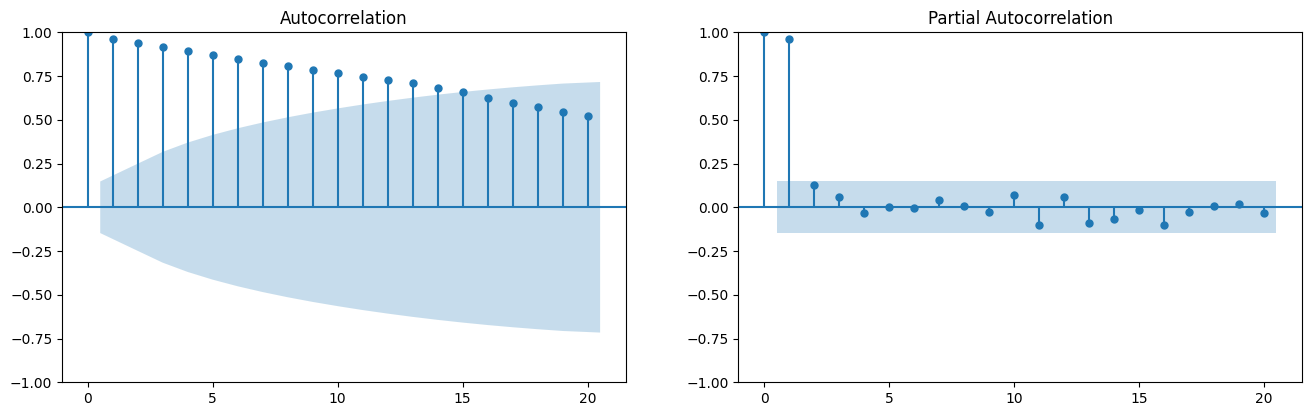

In [23]:
acf_pacf(df_train['y'], 20)

In [24]:
models = {
    'RandomForestRegressor': RandomForestRegressor(),
    'LinearRegression': LinearRegression(),
    'MLPRegressor': MLPRegressor(),
    'KNeighborsRegressor': KNeighborsRegressor(),
    'XGBRegressor': XGBRegressor(),
    'LGBMRegressor': lgb.LGBMRegressor()
}

In [25]:
fcst = MLForecast(
    models=models,
    freq='M',
    lags=[x for x in range(1, 14)],
)

In [26]:
fcst.fit(df_train, id_col='unique_id', time_col='ds', target_col='y')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 611
[LightGBM] [Info] Number of data points in the train set: 138, number of used features: 13
[LightGBM] [Info] Start training from score 362815.695652
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

MLForecast(models=[RandomForestRegressor, LinearRegression, MLPRegressor, KNeighborsRegressor, XGBRegressor, LGBMRegressor], freq=M, lag_features=['lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12', 'lag13'], date_features=[], num_threads=1)

In [27]:
len(df_test)

18

In [28]:
predict = fcst.predict(6)

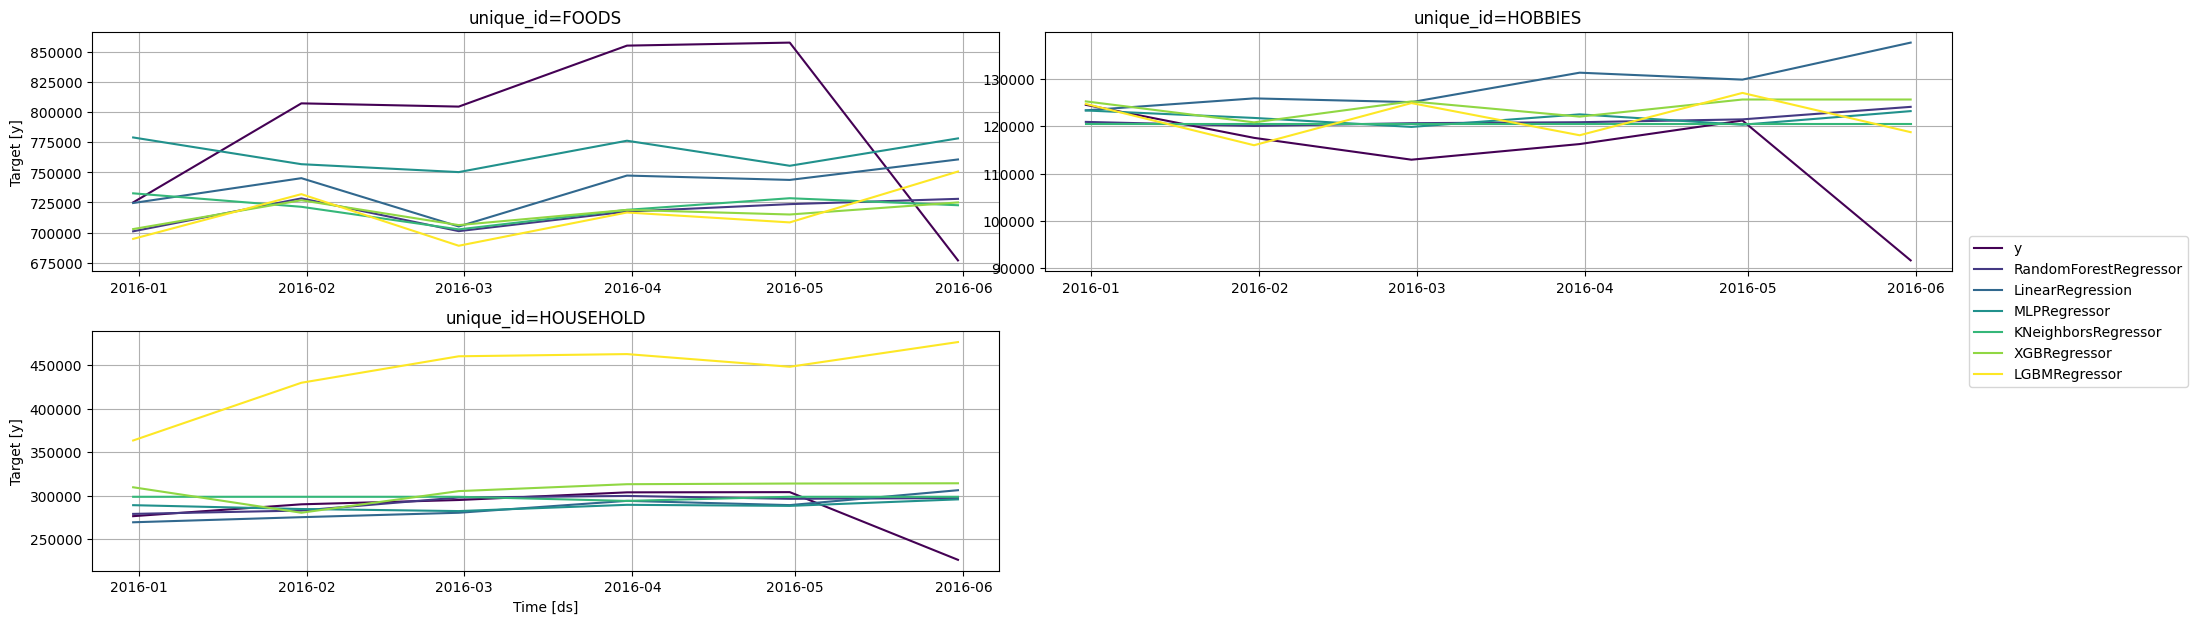

In [29]:
plot_series(df_test, predict, plot_random=False)

analisando o melhor modelo

In [30]:
for i in list(models.keys()):
  print(f'------------------{i}-----------------')
  MAE = mean_absolute_error(df_test['y'], predict[i])
  print(f'Mean Absolute Error: {MAE}')

  MAPE = mean_absolute_percentage_error(df_test['y'], predict[i])
  print(f'Mean absolute percentage error: {MAPE}')

  RMSE = sqrt(mean_squared_error(df_test['y'], predict[i]))
  print(f'Root mean squared error: {RMSE}')

  R2 = r2_score(df_test['y'], predict[i])
  print(f'R2: {R2}')
  print('\n')

------------------RandomForestRegressor-----------------
Mean Absolute Error: 37597.735
Mean absolute percentage error: 0.08687169287637161
Root mean squared error: 59444.18759070502
R2: 0.9577905019428072


------------------LinearRegression-----------------
Mean Absolute Error: 38956.419270833336
Mean absolute percentage error: 0.1131501171889767
Root mean squared error: 55487.38636934872
R2: 0.9632226824760437


------------------MLPRegressor-----------------
Mean Absolute Error: 34641.460069444445
Mean absolute percentage error: 0.08845498053477424
Root mean squared error: 48436.12000696199
R2: 0.9719759821891785


------------------KNeighborsRegressor-----------------
Mean Absolute Error: 37681.522569444445
Mean absolute percentage error: 0.08872375647367473
Root mean squared error: 58826.19999655968
R2: 0.9586635828018188


------------------XGBRegressor-----------------
Mean Absolute Error: 41664.678385416664
Mean absolute percentage error: 0.10501809699720589
Root mean squared 

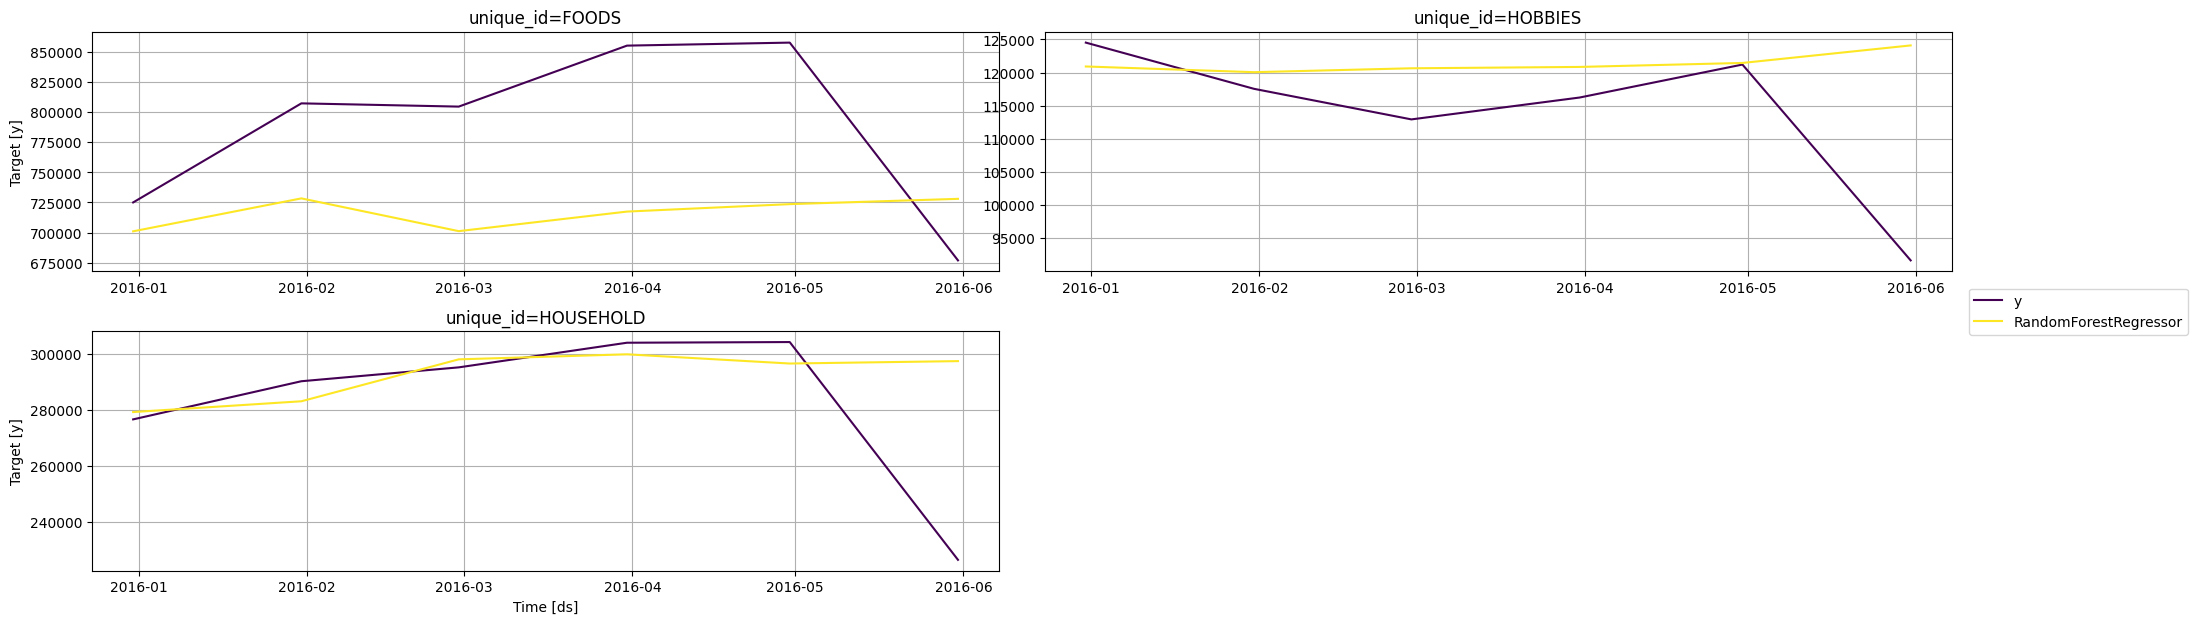

In [31]:
plot_series(df_test, predict[['unique_id', 'ds', 'RandomForestRegressor']], plot_random=False)

In [32]:
previsao = df_test.merge(predict, how='right', on=['unique_id', 'ds'])
previsao.head()

,unique_id,ds,y,RandomForestRegressor,LinearRegression,MLPRegressor,KNeighborsRegressor,XGBRegressor,LGBMRegressor
0,FOODS,2015-12-31,725042,701013.83,724549.8125,779078.7500,732616.6250,702882.3125,694726.281035
1,FOODS,2016-01-31,807440,728410.41,745217.5625,756843.3750,721404.1875,726850.2500,731926.917052
2,FOODS,2016-02-29,804739,701164.64,705033.0000,750262.5625,702626.6250,706184.6250,689009.700042
3,FOODS,2016-03-31,855454,717426.92,747396.8750,776363.0000,718867.0000,718832.2500,716676.451918
4,FOODS,2016-04-30,857962,723619.95,743764.4375,755522.1875,728543.8125,715002.5000,708426.776355


In [33]:
previsao.to_csv('treinamento/treino_categoria_treino.csv')

Treinando o melhor modelo

In [34]:
models = {
    'RandomForestRegressor' : RandomForestRegressor()
}

fcst = MLForecast(
    models=models,
    freq='MS',
    lags=[1, 6, 12]
)

In [35]:
dados_full = pd.concat([df_train, df_test])
fcst.fit(dados_full)

MLForecast(models=[RandomForestRegressor], freq=MS, lag_features=['lag1', 'lag6', 'lag12'], date_features=[], num_threads=1)

In [36]:
import pickle
with open('Modelos/modelo_previsao_categoria.pkl', 'wb') as file:
    pickle.dump(fcst, file)

In [37]:
previsao = fcst.predict(6)
previsao['RandomForestRegressor'] = previsao['RandomForestRegressor'].astype(int)
previsao

,unique_id,ds,RandomForestRegressor
0,FOODS,2016-06-01,737262
1,FOODS,2016-07-01,777882
2,FOODS,2016-08-01,814830
3,FOODS,2016-09-01,817651
4,FOODS,2016-10-01,806298
5,FOODS,2016-11-01,779720
6,HOBBIES,2016-06-01,99908
7,HOBBIES,2016-07-01,98663
8,HOBBIES,2016-08-01,98561
9,HOBBIES,2016-09-01,98620


In [38]:
previsao.to_csv('previsao/previsao_categoria_LinearRegression.csv')